In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# functions from here: https://github.com/atiselsts/uniswap-v3-liquidity-math/blob/master/uniswap-v3-liquidity-math.py
def get_liquidity_0(x, sa, sb):
    return x * sa * sb / (sb - sa)

def get_liquidity_1(y, sa, sb):
    return y / (sb - sa)

def get_liquidity(x, y, sp, sa, sb):
    if sp <= sa:
        liquidity = get_liquidity_0(x, sa, sb)
    elif sp < sb:
        liquidity0 = get_liquidity_0(x, sp, sb)
        liquidity1 = get_liquidity_1(y, sa, sp)
        liquidity = min(liquidity0, liquidity1)
    else:
        liquidity = get_liquidity_1(y, sa, sb)
    return liquidity

def calculate_x(L, sp, sa, sb):
    sp = max(min(sp, sb), sa)     # if the price is outside the range, use the range endpoints instead
    return L * (sb - sp) / (sp * sb)

def calculate_y(L, sp, sa, sb):
    sp = max(min(sp, sb), sa)     # if the price is outside the range, use the range endpoints instead
    return L * (sp - sa)

def calculateAmounts(p, a, b, x, y, P1):
    sp = p ** 0.5
    sa = a ** 0.5
    sb = b ** 0.5
    L = get_liquidity(x, y, sp, sa, sb)

    sp1 = P1 ** 0.5

    sp = max(min(sp, sb), sa)
    sp1 = max(min(sp1, sb), sa)

    delta_p = sp1 - sp
    delta_inv_p = 1/sp1 - 1/sp
    delta_x = delta_inv_p * L
    delta_y = delta_p * L
    x1 = x + delta_x
    y1 = y + delta_y
    
    return x1, y1

def find_max_x(p, a, b, vMax):
    sp = p ** 0.5
    sa = a ** 0.5
    sb = b ** 0.5
    x = 0.001  # starting value for x
    step = 0.001
    while True:
        L = get_liquidity_0(x, sp, sb)
        y = calculate_y(L, sp, sa, sb)
        v = x*p + y
        if v >= vMax:
            break
        x += step
    return x - step

def find_max_x2(p, a, b, vMax): # KZ: find_max_x using brute force method, could cost a large gas fee. and find_max_x2 has the same solution, with less calculation cost
    sp = p ** 0.5
    sa = a ** 0.5
    sb = b ** 0.5
    x2 = vMax/((sp-sa)*sp*sb/(sb-sp)+p)
    return x2

x=find_max_x(1000, 800, 1200, 1000)
x2=find_max_x2(1000, 800, 1200, 1000)
print("X = {:.3f}".format(x))
print("X2 = {:.3f}".format(x2))

X = 0.452
X2 = 0.452


In [3]:
def find_equal_pnl_values(p, a, b, P1, short_price, maximumValue):
    tolerance = 5  # a small tolerance for comparing PNLs; adjust as needed
    step = 1 

    initial_portfolio_value_v3 = 0

    while initial_portfolio_value_v3 <= maximumValue:
        # Calculate PNL_V3
        x = find_max_x(p, a, b, initial_portfolio_value_v3)
        y = initial_portfolio_value_v3 - x * p
        x1, y1 = calculateAmounts(p, a, b, x, y, P1)
        value = x * p + y
        value1 = x1 * P1 + y1
        PNL_V3 = value1 - value
        # Calculate PNL_short
        initial_portfolio_value_short = maximumValue - initial_portfolio_value_v3
        profit_loss = (short_price - P1) / short_price
        PNL_short = initial_portfolio_value_short * profit_loss
        
        # Check if the PNLs are approximately equal
        if abs(PNL_V3 + PNL_short) <= tolerance:
            return initial_portfolio_value_v3, initial_portfolio_value_short
        
        initial_portfolio_value_v3 += step

    return None, None


# KZ: find_equal_pnl_values using brute force method, could cost a large gas fee. and find_equal_pnl_values2 has the same solution, with less calculation cost
# KZ: Moreover, the find_equal_pnl_values2 has better accuracy
def find_equal_pnl_values2(p, a, b, P1, short_price, maximumValue):
    # Calculate PNL_V3
    Virturl_LP=1000 


    x = find_max_x(p, a, b, Virturl_LP)  # KZ: what's x at p
    y = Virturl_LP - x * p
    x1, y1 = calculateAmounts(p, a, b, x, y, P1)
    value = x * p + y
    value1 = x1 * P1 + y1
    PNL_V3 = value1 - value  # KZ: the calculate imp loss

   
    # Calculate PNL_short position
    Virturl_Short=PNL_V3/(P1-short_price)*short_price
    print("x0 = {:.2f}".format(PNL_V3))
    print("y0 = {:.2f}".format(Virturl_Short))
    
    initial_portfolio_value_v3=Virturl_LP
    initial_portfolio_value_short=Virturl_Short

    return initial_portfolio_value_v3, initial_portfolio_value_short

## Calculating Impermanent Loss

* p = current price
* a = lower price bound for LP position
* b = upper price bound for LP position

In [4]:
# Test
p = 1000 # current price
a = p - (1000 * 0.2) # lower price 10% below current price 
b = p + (1000 * 0.2) # upper price 10% above current price 
short_price = 1000
maximumPortfolioValue = 1000  # initial value of the porfolio


In [5]:

initial_portfolio_value_v3, initial_portfolio_value_short = find_equal_pnl_values(p, a, b, a, short_price, maximumPortfolioValue)

print("initial_portfolio_value_v3 = {:.2f}".format(initial_portfolio_value_v3))
print("initial_portfolio_value_short = {:.2f}".format(initial_portfolio_value_short))

# test for find_equal_pnl_values2 function
initial_portfolio_value_v3, initial_portfolio_value_short = find_equal_pnl_values2(p, a, b, 1100, short_price, maximumPortfolioValue)
print("initial_portfolio_value_v3 = {:.2f}".format(initial_portfolio_value_v3))
print("initial_portfolio_value_short = {:.2f}".format(initial_portfolio_value_short))

# KZ: simulating price moving with different directions will result the LPvalue/Shortvalue ratio different. 
initial_portfolio_value_v3_up, initial_portfolio_value_short_up = find_equal_pnl_values(p, a, b, 1100, short_price, maximumPortfolioValue)
print("initial_portfolio_value_v3_up = {:.2f}".format(initial_portfolio_value_v3_up))
print("initial_portfolio_value_short_up = {:.2f}".format(initial_portfolio_value_short_up))

# KZ: accuracy test
initial_portfolio_value_v3_Ndown, initial_portfolio_value_short_Ndown = find_equal_pnl_values(p, a, b, 999, short_price, maximumPortfolioValue)
print("initial_portfolio_value_v3_Ndown = {:.2f}".format(initial_portfolio_value_v3_Ndown))
print("initial_portfolio_value_short_Ndown = {:.2f}".format(initial_portfolio_value_short_Ndown))

initial_portfolio_value_v3_Ndown, initial_portfolio_value_short_Ndown = find_equal_pnl_values2(p, a, b, 999, short_price, maximumPortfolioValue)
print("initial_portfolio_value_v3_Ndown = {:.2f}".format(initial_portfolio_value_v3_Ndown))
print("initial_portfolio_value_short_Ndown = {:.2f}".format(initial_portfolio_value_short_Ndown))

initial_portfolio_value_v3 = 561.00
initial_portfolio_value_short = 439.00
x0 = 32.84
y0 = 328.41
initial_portfolio_value_v3 = 1000.00
initial_portfolio_value_short = 328.41
initial_portfolio_value_v3_up = 716.00
initial_portfolio_value_short_up = 284.00
initial_portfolio_value_v3_Ndown = 0.00
initial_portfolio_value_short_Ndown = 1000.00
x0 = -0.45
y0 = 453.30
initial_portfolio_value_v3_Ndown = 1000.00
initial_portfolio_value_short_Ndown = 453.30


# my suggestion to select hedge possiton, Average of lower case and upper case. It is not beautiful but simple. 

In [6]:
initial_portfolio_value_v3Lower, initial_portfolio_value_shortLower = find_equal_pnl_values2(p, a, b, a, short_price, maximumPortfolioValue)
print("initial_portfolio_value_v3Lower = {:.2f}".format(initial_portfolio_value_v3Lower))
print("initial_portfolio_value_shortLower = {:.2f}".format(initial_portfolio_value_shortLower))

initial_portfolio_value_v3Upper, initial_portfolio_value_shortUpper = find_equal_pnl_values2(p, a, b, b, short_price, maximumPortfolioValue)
print("initial_portfolio_value_v3Upper = {:.2f}".format(initial_portfolio_value_v3Upper))
print("initial_portfolio_value_shortUpper = {:.2f}".format(initial_portfolio_value_shortUpper))

# my suggestion to select hedge possiton, Average of lower case and upper case. It is not beautiful but simple. 
initial_portfolio_value_v3=maximumPortfolioValue*(initial_portfolio_value_v3Lower+initial_portfolio_value_v3Upper)/(initial_portfolio_value_v3Lower+initial_portfolio_value_shortLower+initial_portfolio_value_v3Upper+initial_portfolio_value_shortUpper)
initial_portfolio_value_short=maximumPortfolioValue-initial_portfolio_value_v3
print("initial_portfolio_value_v3Mid = {:.2f}".format(initial_portfolio_value_v3))
print("initial_portfolio_value_shortMid = {:.2f}".format(initial_portfolio_value_short))

x0 = -148.22
y0 = 741.10
initial_portfolio_value_v3Lower = 1000.00
initial_portfolio_value_shortLower = 741.10
x0 = 43.14
y0 = 215.71
initial_portfolio_value_v3Upper = 1000.00
initial_portfolio_value_shortUpper = 215.71
initial_portfolio_value_v3Mid = 676.41
initial_portfolio_value_shortMid = 323.59


In [7]:
initial_portfolio_value_v3,initial_portfolio_value_short

(676.4053469025633, 323.59465309743666)

In [8]:
initial_portfolio_value_v3+initial_portfolio_value_short

1000.0

In [9]:
initial_portfolio_value_short / initial_portfolio_value_v3

0.4784034522779293

In [10]:
# ADJUST short/long bias
# initial_portfolio_value_v3 = maximumPortfolioValue * 0.677
# initial_portfolio_value_short = maximumPortfolioValue * 0.323

In [11]:
initial_portfolio_value_v3,initial_portfolio_value_short

(676.4053469025633, 323.59465309743666)

In [12]:
initial_portfolio_value_v3+initial_portfolio_value_short

1000.0

In [13]:
# token0 and token1 amounts given initial_portfolio_value_v3 and price
vMax = initial_portfolio_value_v3 # initial portfolio value

x = find_max_x(p, a, b, vMax)
y = vMax - x * p
print("Maximum # of ETH {:.3f}".format(x))
print("Maximum # of USDC {:.3f}".format(y))

Maximum # of ETH 0.305
Maximum # of USDC 371.405


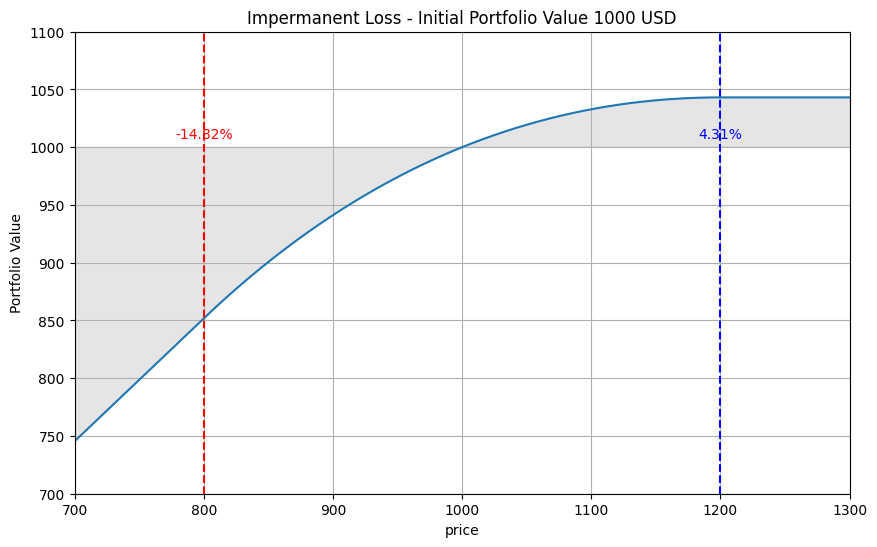

In [14]:
## PLOT IL
x_1 = find_max_x(p, a, b, maximumPortfolioValue)
y_1 = maximumPortfolioValue - x_1 * p

# Create empty lists to store the values
P1_values = []
value_values = []

# Loop through the range of P1 from 500 to 1500
for P1 in range(500, 1501):
    x1, y1 = calculateAmounts(p, a, b, x_1, y_1, P1)  # Calculate x1 and y1 based on the given function
    value = x1 * P1 + y1  # Calculate the value based on the given formula
    
    # Append the P1 and value to their respective lists
    P1_values.append(P1)
    value_values.append(value)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(P1_values, value_values, linestyle='-')
plt.title('Impermanent Loss - Initial Portfolio Value 1000 USD')
plt.xlabel('price')
plt.ylabel('Portfolio Value')
plt.grid(True)

# Calculate percentage changes at 'a' and 'b'
value_at_a = calculateAmounts(p, a, b, x_1, y_1, a)[0] * a + calculateAmounts(p, a, b, x_1, y_1, a)[1]
percent_change_a = ((value_at_a - maximumPortfolioValue) / maximumPortfolioValue) * 100

value_at_b = calculateAmounts(p, a, b, x_1, y_1, b)[0] * b + calculateAmounts(p, a, b, x_1, y_1, b)[1]
percent_change_b = ((value_at_b - maximumPortfolioValue) / maximumPortfolioValue) * 100

# Add vertical dotted lines for points 'a' and 'b'
plt.axvline(x=a, color='r', linestyle='--')
plt.axvline(x=b, color='b', linestyle='--')

# Shade the difference area
where_condition = [value != maximumPortfolioValue for value in value_values]
plt.fill_between(P1_values, value_values, maximumPortfolioValue, where=where_condition, interpolate=True, color='grey', alpha=0.2)

# Place the percent change on the sides of the chart
plt.text(a, maximumPortfolioValue + 5, f'{percent_change_a:.2f}%', color='r', ha='center', va='bottom')
plt.text(b, maximumPortfolioValue + 5, f'{percent_change_b:.2f}%', color='b', ha='center', va='bottom')

plt.xlim(a-100, b+100)
plt.ylim(700, 1100)

# Show the plot
plt.show()

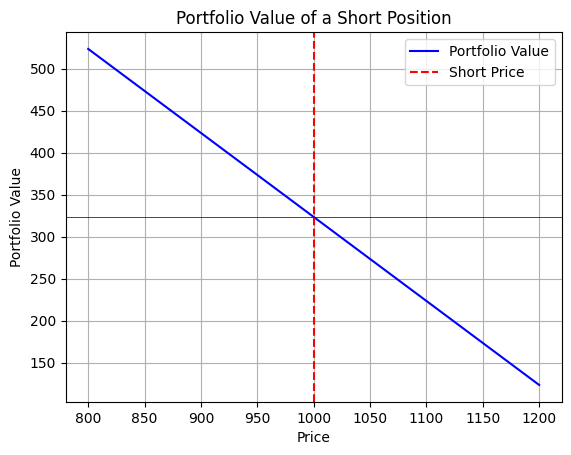

In [15]:
# Constants
initial_portfolio_value = initial_portfolio_value_short # using value from above

# Price range for our graph
prices = np.linspace(800, 1200, 100)

# Calculate P&L for each price point
profit_loss = short_price - prices

# Calculate Portfolio Value for each P&L
portfolio_values = initial_portfolio_value + profit_loss

# Plotting
plt.plot(prices, portfolio_values, label='Portfolio Value', color='blue')
plt.axhline(initial_portfolio_value, color='black',linewidth=0.5)
plt.axvline(short_price, color='red', linestyle='--', label='Short Price')
plt.title('Portfolio Value of a Short Position')
plt.xlabel('Price')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
profit_loss = (short_price - P1) / short_price
PNL_short = initial_portfolio_value_short * profit_loss + initial_portfolio_value_short


In [17]:
print(profit_loss)
print(PNL_short)

-0.5
161.79732654871833


In [18]:
initial_portfolio_value_short + initial_portfolio_value_v3

1000.0

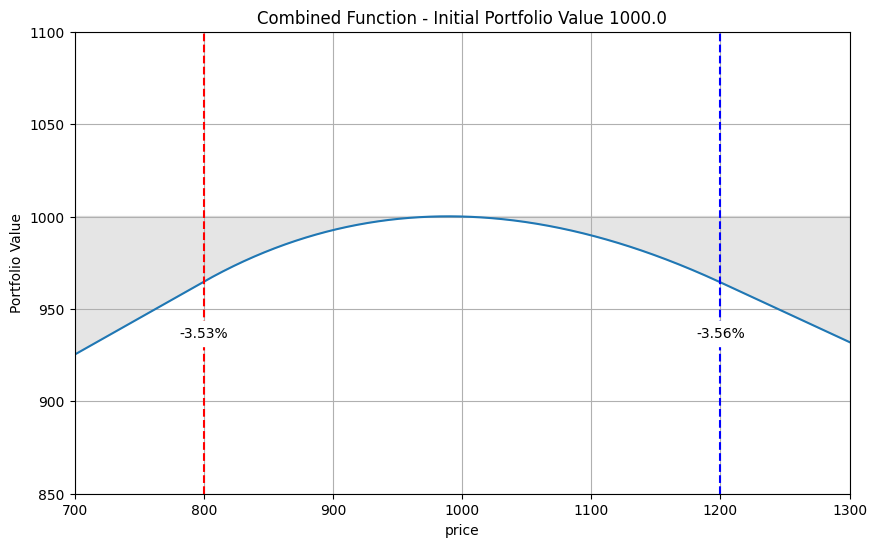

In [19]:
initial_portfolio_value = initial_portfolio_value_short # using value from above

# Create empty lists to store the values
P1_values = []
value_values = []

# Loop through the range of P1 from 500 to 1500
for P1 in range(500, 1501):
    x1, y1 = calculateAmounts(p, a, b, x, y, P1)  # Calculate x1 and y1 based on the given function
    value = x1 * P1 + y1  # Calculate the value based on the given formula
    
    profit_loss = (short_price - P1) / short_price
    PNL_short = initial_portfolio_value_short * profit_loss + initial_portfolio_value_short
    
    value1 = value + PNL_short

    # Append the P1 and value to their respective lists
    P1_values.append(P1)
    value_values.append(value1)
plt.figure(figsize=(10, 6))
plt.plot(P1_values, value_values, linestyle='-')
plt.title('Combined Function - Initial Portfolio Value {}'.format(initial_portfolio_value_short + initial_portfolio_value_v3))
plt.xlabel('price')
plt.ylabel('Portfolio Value')
plt.grid(True)

# Calculate the percentage differences where the portfolio value crosses p
index_at_a = P1_values.index(a)
index_at_b = P1_values.index(b)
percent_difference_at_a = ((value_values[index_at_a] - p) / p) * 100
percent_difference_at_b = ((value_values[index_at_b] - p) / p) * 100

# Add vertical dotted lines for points 'a' and 'b'
plt.axvline(x=a, color='r', linestyle='--')
plt.axvline(x=b, color='b', linestyle='--')

# Shade the area where the portfolio value is not equal to p between a and b
where_condition = [value < p or value > p for value in value_values]
plt.fill_between(P1_values, value_values, p, where=where_condition, interpolate=True, color='grey', alpha=0.2)

# Use text to display percent difference:
# Adjust positioning based on whether the curve is above or below p
vertical_offset_a = 10 if value_values[index_at_a] > p else -30
vertical_offset_b = 10 if value_values[index_at_b] > p else -30

plt.text(a, value_values[index_at_a] + vertical_offset_a, f'{percent_difference_at_a:.2f}%', fontsize=10, ha='center', backgroundcolor='white')
plt.text(b, value_values[index_at_b] + vertical_offset_b, f'{percent_difference_at_b:.2f}%', fontsize=10, ha='center', backgroundcolor='white')

plt.xlim(a - 100, b + 100)
plt.ylim(850, 1100)

# Show the plot
plt.show()

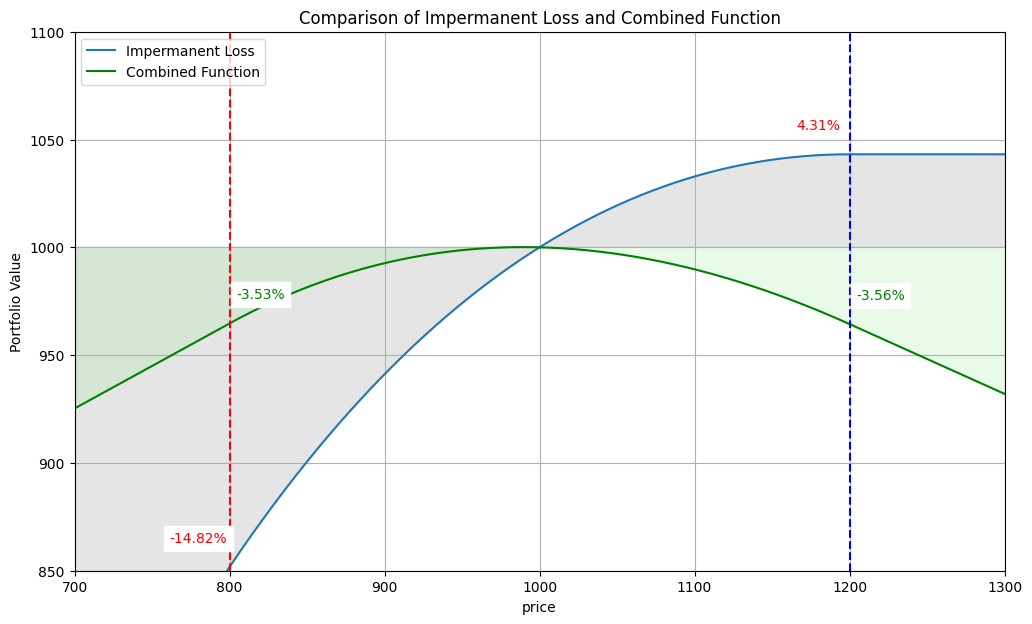

In [20]:
# Assuming required libraries and functions are already imported
# Also, variables such as p, a, b, maximumPortfolioValue, x, y, short_price, initial_portfolio_value_short, and initial_portfolio_value_v3 are predefined

# Create empty lists to store values for the first plot
P1_values_1 = []
value_values_1 = []

for P1 in range(500, 1501):
    x1, y1 = calculateAmounts(p, a, b, x_1, y_1, P1)  # Calculate x1 and y1 based on the given function
    value = x1 * P1 + y1  # Calculate the value based on the given formula
    
    P1_values_1.append(P1)
    value_values_1.append(value)

# Create empty lists to store values for the second plot
P1_values_2 = []
value_values_2 = []

for P1 in range(500, 1501):
    x1, y1 = calculateAmounts(p, a, b, x, y, P1)  # Calculate x1 and y1 based on the given function
    value = x1 * P1 + y1  # Calculate the value based on the given formula
    
    profit_loss = (short_price - P1) / short_price
    PNL_short = initial_portfolio_value_short * profit_loss + initial_portfolio_value_short
    
    value1 = value + PNL_short

    P1_values_2.append(P1)
    value_values_2.append(value1)

plt.figure(figsize=(12, 7))

# Plot the data for both functions
plt.plot(P1_values_1, value_values_1, linestyle='-', label="Impermanent Loss")
plt.plot(P1_values_2, value_values_2, linestyle='-', label="Combined Function", color='green')

plt.title('Comparison of Impermanent Loss and Combined Function')
plt.xlabel('price')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend(loc="upper left")

# Add vertical dotted lines for points 'a' and 'b'
plt.axvline(x=a, color='r', linestyle='--')
plt.axvline(x=b, color='b', linestyle='--')

# Calculate the percentage difference of each function from p at a and b
percent_diff_1_at_a = ((value_values_1[index_at_a] - p) / p) * 100
percent_diff_1_at_b = ((value_values_1[index_at_b] - p) / p) * 100

percent_diff_2_at_a = ((value_values_2[index_at_a] - p) / p) * 100
percent_diff_2_at_b = ((value_values_2[index_at_b] - p) / p) * 100

# Place the percentage differences on the chart
# For the first function:
plt.text(a-20, value_values_1[index_at_a] + 10, f'{percent_diff_1_at_a:.2f}%', color='r', ha='center', va='bottom', backgroundcolor='white')
plt.text(b-20, value_values_1[index_at_b] + 10, f'{percent_diff_1_at_b:.2f}%', color='r', ha='center', va='bottom', backgroundcolor='white')

# For the second function:
plt.text(a+20, value_values_2[index_at_a] + 10, f'{percent_diff_2_at_a:.2f}%', color='green', ha='center', va='bottom', backgroundcolor='white')
plt.text(b+20, value_values_2[index_at_b] + 10, f'{percent_diff_2_at_b:.2f}%', color='green', ha='center', va='bottom', backgroundcolor='white')

# Shade the difference areas
where_condition_1 = [value != maximumPortfolioValue for value in value_values_1]
plt.fill_between(P1_values_1, value_values_1, maximumPortfolioValue, where=where_condition_1, interpolate=True, color='grey', alpha=0.2)
where_condition_2 = [value < p or value > p for value in value_values_2]
plt.fill_between(P1_values_2, value_values_2, p, where=where_condition_2, interpolate=True, color='lightgreen', alpha=0.2)

plt.xlim(a - 100, b + 100)
plt.ylim(850, 1100)

# Show the plot
plt.show()

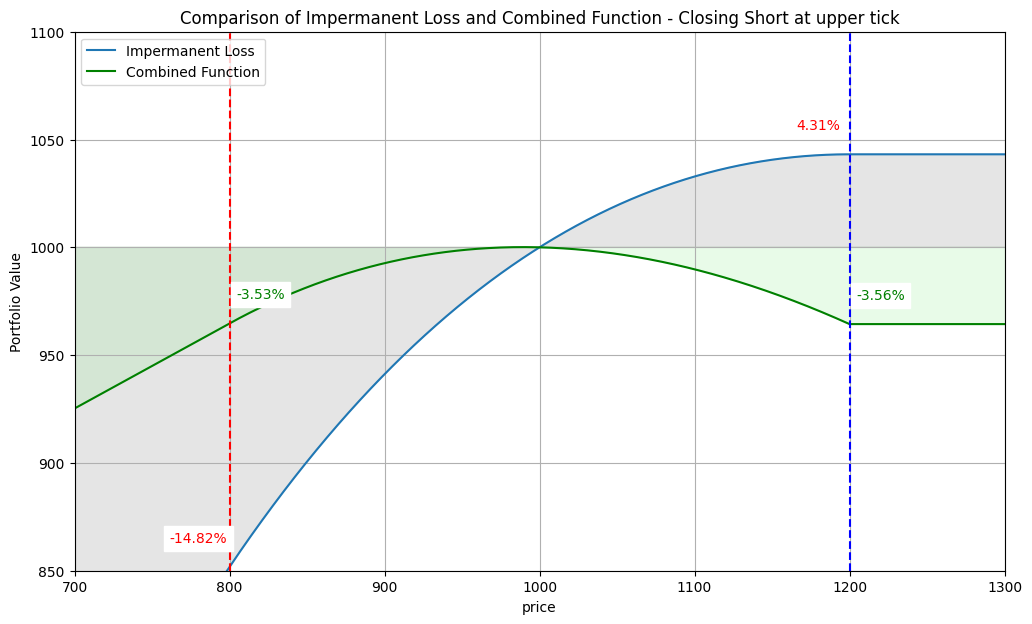

In [21]:
# KZ: the price_close_short case might not make sense to me. What if price drop back to 900-1100 after touch 1100, the loss would increase significantly since the hedge position is closed at the high price. For example, when price back 1000, no profit add to LP, but loss had been realized in short, that the total profit shown in the below figure should be lower than 0.

# KZ: A more feasible way would be auto-adjusting short position, adjusting the neutral position from point 1000 to point 1100, which is a continue adjusting process as market price fluctuation or trigger at some price interval/time. adjusting cost always occurs but under control.

price_close_short = b

P1_values_1 = []
value_values_1 = []

for P1 in range(500, 1501):
    x1, y1 = calculateAmounts(p, a, b, x_1, y_1, P1)
    value = x1 * P1 + y1
    
    P1_values_1.append(P1)
    value_values_1.append(value)

P1_values_2 = []
value_values_2 = []

for P1 in range(500, 1501):
    x1, y1 = calculateAmounts(p, a, b, x, y, P1)  # Calculate x1 and y1 based on the given function
    value = x1 * P1 + y1  # Calculate the value based on the given formula
    
    PNL_short = 0
    
    if P1 < price_close_short:
            profit_loss = (short_price - P1) / short_price
            PNL_short = initial_portfolio_value_short * profit_loss + initial_portfolio_value_short
    else:
            profit_loss = (short_price - price_close_short) / short_price
            PNL_short = initial_portfolio_value_short + (initial_portfolio_value_short * profit_loss)
    
    value1 = value + PNL_short

    P1_values_2.append(P1)
    value_values_2.append(value1)

plt.figure(figsize=(12, 7))

# Plot the data for both functions
plt.plot(P1_values_1, value_values_1, linestyle='-', label="Impermanent Loss")
plt.plot(P1_values_2, value_values_2, linestyle='-', label="Combined Function", color='green')

plt.title('Comparison of Impermanent Loss and Combined Function - Closing Short at upper tick')
plt.xlabel('price')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend(loc="upper left")

# Add vertical dotted lines for points 'a' and 'b'
plt.axvline(x=a, color='r', linestyle='--')
plt.axvline(x=b, color='b', linestyle='--')

# Calculate the percentage difference of each function from p at a and b
percent_diff_1_at_a = ((value_values_1[index_at_a] - p) / p) * 100
percent_diff_1_at_b = ((value_values_1[index_at_b] - p) / p) * 100

percent_diff_2_at_a = ((value_values_2[index_at_a] - p) / p) * 100
percent_diff_2_at_b = ((value_values_2[index_at_b] - p) / p) * 100

# Place the percentage differences on the chart
# For the first function:
plt.text(a-20, value_values_1[index_at_a] + 10, f'{percent_diff_1_at_a:.2f}%', color='r', ha='center', va='bottom', backgroundcolor='white')
plt.text(b-20, value_values_1[index_at_b] + 10, f'{percent_diff_1_at_b:.2f}%', color='r', ha='center', va='bottom', backgroundcolor='white')

# For the second function:
plt.text(a+20, value_values_2[index_at_a] + 10, f'{percent_diff_2_at_a:.2f}%', color='green', ha='center', va='bottom', backgroundcolor='white')
plt.text(b+20, value_values_2[index_at_b] + 10, f'{percent_diff_2_at_b:.2f}%', color='green', ha='center', va='bottom', backgroundcolor='white')

# Shade the difference areas
where_condition_1 = [value != maximumPortfolioValue for value in value_values_1]
plt.fill_between(P1_values_1, value_values_1, maximumPortfolioValue, where=where_condition_1, interpolate=True, color='grey', alpha=0.2)
where_condition_2 = [value < p or value > p for value in value_values_2]
plt.fill_between(P1_values_2, value_values_2, p, where=where_condition_2, interpolate=True, color='lightgreen', alpha=0.2)

plt.xlim(a - 100, b + 100)
plt.ylim(850, 1100)

# Show the plot
plt.show()

In [22]:
# WITH LEVERAGE

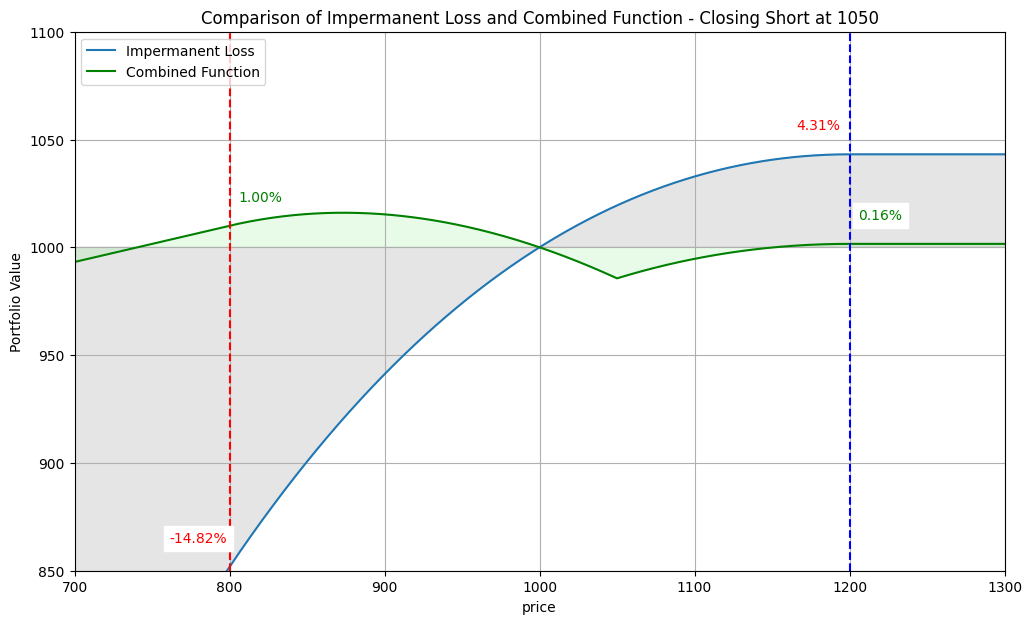

In [23]:
leverage = 1.7
price_close_short = 1050

# Create empty lists to store values for the first plot
P1_values_1 = []
value_values_1 = []

for P1 in range(500, 1501):
    x1, y1 = calculateAmounts(p, a, b, x_1, y_1, P1)  # Calculate x1 and y1 based on the given function
    value = x1 * P1 + y1  # Calculate the value based on the given formula
    
    P1_values_1.append(P1)
    value_values_1.append(value)

# Create empty lists to store values for the second plot
P1_values_2 = []
value_values_2 = []

for P1 in range(500, 1501):
    x1, y1 = calculateAmounts(p, a, b, x, y, P1)  # Calculate x1 and y1 based on the given function
    value = x1 * P1 + y1  # Calculate the value based on the given formula
    
    PNL_short = 0
    
    
    if P1 < price_close_short:
            profit_loss = (short_price - P1) / short_price
            PNL_short = initial_portfolio_value_short * profit_loss * leverage + initial_portfolio_value_short
    else:
            profit_loss = (short_price - price_close_short) / short_price
            PNL_short = initial_portfolio_value_short + (initial_portfolio_value_short * profit_loss * leverage)
    
    value1 = value + PNL_short


    P1_values_2.append(P1)
    value_values_2.append(value1)

plt.figure(figsize=(12, 7))

# Plot the data for both functions
plt.plot(P1_values_1, value_values_1, linestyle='-', label="Impermanent Loss")
plt.plot(P1_values_2, value_values_2, linestyle='-', label="Combined Function", color='green')

plt.title('Comparison of Impermanent Loss and Combined Function - Closing Short at 1050')
plt.xlabel('price')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend(loc="upper left")

# Add vertical dotted lines for points 'a' and 'b'
plt.axvline(x=a, color='r', linestyle='--')
plt.axvline(x=b, color='b', linestyle='--')

# Calculate the percentage difference of each function from p at a and b
percent_diff_1_at_a = ((value_values_1[index_at_a] - p) / p) * 100
percent_diff_1_at_b = ((value_values_1[index_at_b] - p) / p) * 100

percent_diff_2_at_a = ((value_values_2[index_at_a] - p) / p) * 100
percent_diff_2_at_b = ((value_values_2[index_at_b] - p) / p) * 100

# Place the percentage differences on the chart
# For the first function:
plt.text(a-20, value_values_1[index_at_a] + 10, f'{percent_diff_1_at_a:.2f}%', color='r', ha='center', va='bottom', backgroundcolor='white')
plt.text(b-20, value_values_1[index_at_b] + 10, f'{percent_diff_1_at_b:.2f}%', color='r', ha='center', va='bottom', backgroundcolor='white')

# For the second function:
plt.text(a+20, value_values_2[index_at_a] + 10, f'{percent_diff_2_at_a:.2f}%', color='green', ha='center', va='bottom', backgroundcolor='white')
plt.text(b+20, value_values_2[index_at_b] + 10, f'{percent_diff_2_at_b:.2f}%', color='green', ha='center', va='bottom', backgroundcolor='white')

# Shade the difference areas
where_condition_1 = [value != maximumPortfolioValue for value in value_values_1]
plt.fill_between(P1_values_1, value_values_1, maximumPortfolioValue, where=where_condition_1, interpolate=True, color='grey', alpha=0.2)
where_condition_2 = [value < p or value > p for value in value_values_2]
plt.fill_between(P1_values_2, value_values_2, p, where=where_condition_2, interpolate=True, color='lightgreen', alpha=0.2)

plt.xlim(a - 100, b + 100)
plt.ylim(850, 1100)

# Show the plot
plt.show()